In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from fbprophet import Prophet

In [2]:
cp_df = pd.read_excel('../Price Predictor/data.xlsx')
cp_df.head(5)

,sku,L1,L2,L3,product_name,date,quantity,price
0,100003005,SNACKS & BRANDED FOODS,SNACKS & NAMKEEN,CHIPS & CORN SNACKS,ACT II MICROWAVE POPCORN - NATURAL,2016-09-16,131958,1173
1,100003379,"FOODGRAINS, OIL & MASALA",EDIBLE OILS & GHEE,OTHER EDIBLE OILS,TIL SONA OIL - TIL,2016-09-16,681155,5426
2,100003486,"FOODGRAINS, OIL & MASALA",EDIBLE OILS & GHEE,OTHER EDIBLE OILS,IDHAYAM OIL - SESAME,2016-09-16,141932,4850
3,100003586,"FOODGRAINS, OIL & MASALA",EDIBLE OILS & GHEE,GHEE & VANASPATI,GOWARDHAN PREMIUM GHEE,2016-09-16,375838,3430
4,100003775,SNACKS & BRANDED FOODS,"NOODLE, PASTA, VERMICELLI",INSTANT NOODLES,TOP RAMEN NOODLES - CHICKEN,2016-09-16,269178,3866


In [3]:
# Since date is not of datetime type
cp_df['date'] = pd.DatetimeIndex(cp_df['date'])

In [4]:
trial_cp_df = cp_df.loc[cp_df['sku'] == 100003967]
trial_cp_df = trial_cp_df[['date','price','quantity']]
trial_cp_df.set_index('date', inplace=True)

In [5]:
#plt.plot(trial_cp_df)
trial_cp_df['price_index'] = trial_cp_df.apply(lambda row: row.price / row.quantity, axis=1)
ts = trial_cp_df['price_index']
ts.head(5)

date
2016-09-16    0.004679
2016-10-25    0.046510
2016-11-26    0.004574
2016-12-24    0.009561
2017-01-24    0.000977
Name: price_index, dtype: float64

In [6]:
# Convert time series to dataframe and rename columns as per Prophet requirement - 'ds' and 'y'
ts_df = pd.DataFrame({'ds':ts.index, 'y':ts.values})
ts_df.head(5)

,ds,y
0,2016-09-16,0.004679
1,2016-10-25,0.046510
2,2016-11-26,0.004574
3,2016-12-24,0.009561
4,2017-01-24,0.000977


In [7]:
# Time series forecasting using Prophet
# set the uncertainty interval to 95% (the Prophet default is 80%)
cp_fs_model = Prophet(growth = 'logistic', changepoint_prior_scale=5.0, weekly_seasonality=False, daily_seasonality=False)
#cp_fs_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [8]:
ts_df['cap'] = 1.5
ts_df['floor'] = 1.0
cp_fs_model.fit(ts_df)

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.
C:\Users\pmanjunath\AppData\Local\Continuum\anaconda3\lib\site-packages\fbprophet\forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
C:\Users\pmanjunath\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [9]:
# Prophet has a built-in helper function make_future_dataframe to create a dataframe of future date
future_dates_df = cp_fs_model.make_future_dataframe(periods=12, freq='MS')
future_dates_df['cap'] = 1.5
future_dates_df['floor'] = 1.0

In [10]:
forecasted_cp_df = cp_fs_model.predict(future_dates_df)
forecasted_cp_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2019-07-01,2.340558,2.079371,2.597093
35,2019-08-01,-16.189867,-16.452865,-15.915594
36,2019-09-01,13.126406,12.858892,13.391068
37,2019-10-01,4.708164,4.454014,4.973186
38,2019-11-01,0.799125,0.541255,1.076407


In [11]:
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecasted_cp_df.loc[:38, 'yhat']-ts_df['y'])**2)) )

RMSE: 0.206326


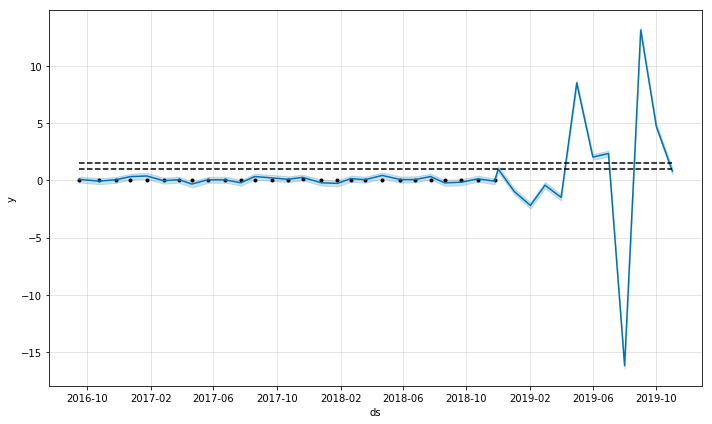

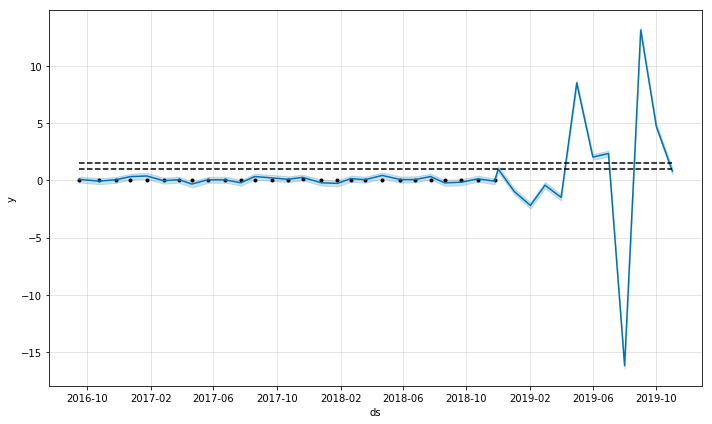

In [12]:
# Function in Prophet to plot the results of our forecasts

# Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and 
# the uncertainty intervals of our forecasts (the blue shaded regions).
cp_fs_model.plot(forecasted_cp_df, uncertainty=True)

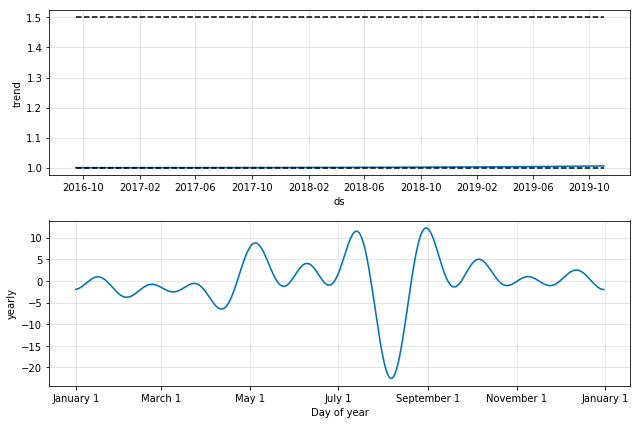

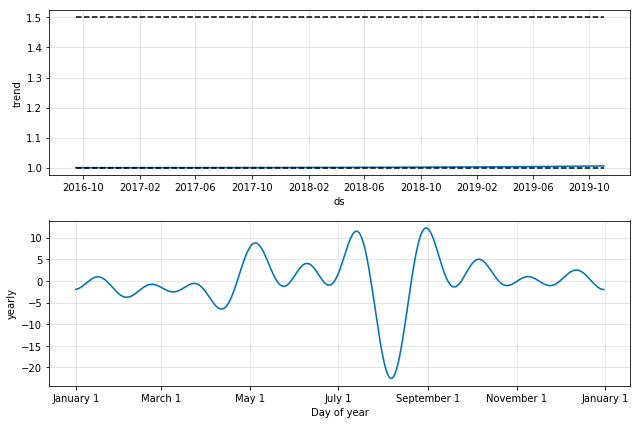

In [13]:
cp_fs_model.plot_components(forecasted_cp_df)

In [14]:
#export_csv = forecasted_cp_df.to_csv ('../Price Predictor/trial_data.csv', index = None, header=True) 

# Convert dataframe into excel and save it
#writer = pd.ExcelWriter('forecasted_cpi.xlsx', engine='xlsxwriter')
#final_forecast_df.to_excel(writer, sheet_name='Sheet1')
#writer.save()